# standard HOD MCMC
standard HOD inference using MCMC

In [1]:
import os
import numpy as np 
import emcee
import warnings
warnings.filterwarnings('ignore')
# -- nbodykit -- 
import nbodykit.lab as NBlab
from nbodykit.hod import Zheng07Model
from halotools.sim_manager import CachedHaloCatalog
# 
import matplotlib.pyplot as plt

# read halo catalog
Only use $x, y, z < 128$ for now. 

In [2]:
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0, halo_finder = 'rockstar')

Lbox = 128.
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < Lbox]
halo_table = halo_table[halo_table['halo_y'] < Lbox]
halo_table = halo_table[halo_table['halo_z'] < Lbox]

In [3]:
halo_data = {} 
halo_data['Position'] = np.vstack([halo_table['halo_x'], halo_table['halo_y'], halo_table['halo_z']]).T
halo_data['Velocity'] = np.vstack([halo_table['halo_vx'], halo_table['halo_vy'], halo_table['halo_vz']]).T
halo_data['Mass'] = halo_table['halo_mvir']

# save to ArryCatalog for consistency
halos = NBlab.ArrayCatalog(halo_data, BoxSize=np.array([Lbox, Lbox, Lbox])) 
halos = NBlab.HaloCatalog(halos, cosmo=NBlab.cosmology.cosmology.Cosmology().from_astropy(halocat.cosmology), redshift=0.0, mdef='vir') 

In [4]:
def model_Pk(theta): 
    ''' For given HOD parameters populate halo and calculate power spectrum
    
    Parameters
    ----------
    theta : 1d array
        hod parameters 
    '''
    gals = halos.populate(
        Zheng07Model, 
        logMmin=theta[0], 
        sigma_logM=theta[1],
        logM0=theta[2], 
        logM1=theta[3],
        alpha=theta[4]
    )
    # calculate power spectrum
    mesh = gals.to_mesh(window='tsc', Nmesh=360, compensated=True, position='Position')

    kf = 2.*np.pi/Lbox # fundamental mode
    r = NBlab.FFTPower(mesh, mode='1d', dk=kf, kmin=kf)
    Pk = r.power
    return Pk['k'], Pk['power'].real - Pk.attrs['shotnoise']

In [5]:
theta_fid = np.array([12.02, 0.26, 11.38, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb

In [6]:
%timeit model_Pk(theta_fid);

3.11 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


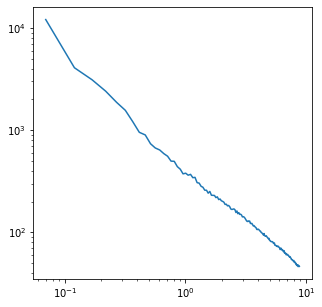

In [7]:
k, pk = model_Pk(theta_fid)
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.plot(k, pk)
sub.set_xscale('log')
sub.set_yscale('log')

# covariance matrix for likelihood

In [10]:
Nmock = 100

fpf = 'pk_fid.%i.npy' % Nmock
if not os.path.isfile(fpf): 
    klim = (k < 1.)
    
    k_arr = k[klim]
    
    pk_fid = np.array([model_Pk(theta_fid)[1] for i in range(Nmock)])[:,klim]
    np.save(fpf, pk_fid)
    np.save('k_arr.npy', k_arr)
else: 
    pk_fid = np.load(fpf)
    k_arr = np.load('k_arr.npy')

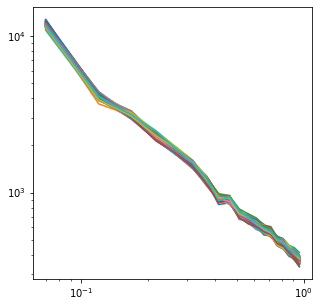

In [11]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
for _pk in pk_fid: 
    sub.plot(k_arr, _pk)
sub.set_xscale('log')
sub.set_yscale('log')

In [12]:
cov_pk = np.cov(pk_fid.T)
cinv_pk = np.linalg.inv(cov_pk)
f_hartlap = (float(Nmock) - float(pk_fid.shape[1]) -2.)/(float(Nmock) - 1.)
print(f_hartlap)

0.797979797979798


In [13]:
pk_obs = np.mean(pk_fid, axis=0) # our "observed P(k)"

In [14]:
def lnProb(theta): 
    '''log probability
    '''
    _, _pk_model = model_Pk(theta)
    pk_model = _pk_model[klim]
    
    dpk = pk_model - pk_obs 
    chi2 = np.dot(dpk, np.dot(cinv_pk, dpk))
    return -0.5*chi2

In [15]:
# 32 walkers
pos = theta_fid + 1e-4 * np.random.randn(32, theta_fid.shape[0])
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb)
sampler.run_mcmc(pos, 5, progress=True);